In [1]:
import pandas as pd
import numpy as np
import cv2
import pathlib
from utils.misc import get_items_on_path
from utils.vision.transformation import get_image_and_reshape, transform_image_contrast, grayscale_mask
from utils.vision.models import unet_model
import matplotlib.pyplot as plt
import hydra
from hydra import initialize, compose
from omegaconf import OmegaConf

from typing import Tuple, Dict
from sklearn.preprocessing import Binarizer

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
initialize("./configs")


hydra.initialize()

In [2]:
from training import prepare_X_and_y

import pandas as pd
import numpy as np
import pathlib
import cv2
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from typing import List, Tuple
from hydra import initialize, compose
from omegaconf import OmegaConf


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, SpatialDropout2D, Concatenate, LeakyReLU, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import Callback

%matplotlib inline
initialize("./configs")


In [3]:
cfg = compose(config_name="config.yaml")
np.random.seed(cfg.project_setup.RANDOM_STATE_N)

PATH_TRAIN_IMAGE_FOLDER = pathlib.Path(cfg.project_setup.paths.data.TRAIN_IMAGE_FOLDER)
PATH_TRAIN_METADATA = pathlib.Path(cfg.project_setup.paths.data.TRAIN_METADATA)

print(OmegaConf.to_yaml(cfg))

project_setup:
  paths:
    data:
      TRAIN_IMAGE_FOLDER: ./data/train
      TRAIN_METADATA: ./data/train.csv
    model:
      MODEL_FOLDER: ./data/models
  RANDOM_STATE_N: 19
  tensorboard:
    SERVER_PORT: 6006
    LOG_DIR: logs
preprocessing:
  INPUT_SHAPE:
    HEIGHT: 520
    WIDTH: 704
  OUTPUT_SHAPE:
    HEIGHT: 512
    WIDTH: 704
  TRANS_POWER: 2
training:
  device:
    GPU: 1
  model:
    LEARNING_RATE: 0.0001
    VAL_SIZE: 0.1
    BATCH_SIZE: 4
    EPOCHS: 20
    PATIENCE: 6



In [4]:
# read meta data
train_metadata = pd.read_csv(PATH_TRAIN_METADATA)

## load all train images into memory as dictionary with image_id as key and the image (np.ndarray) as value
input_img_shape = (cfg.preprocessing.INPUT_SHAPE.HEIGHT, cfg.preprocessing.INPUT_SHAPE.WIDTH)

train_images_paths = get_items_on_path(PATH_TRAIN_IMAGE_FOLDER)
train_images = [get_image_and_reshape(train_image_path, input_img_shape) for train_image_path in train_images_paths]
train_images_dict = {image_id: image for image, image_id in train_images}

Data Preparation
Loading and Transforming the images into their corresponding grayscale masks

In [5]:
X, y = prepare_X_and_y(cfg=cfg, ids_and_images=train_images_dict, metadata=train_metadata)

image_ids=list(train_images_dict.keys())
np.random.shuffle(image_ids)

X = []
y = []

for imd_id in image_ids:
    # prepare x
    image = train_images_dict[imd_id]
    prepared_x_2d = cv2.resize(
        transform_image_contrast(image, cfg.preprocessing.TRANS_POWER), 
        (cfg.preprocessing.OUTPUT_SHAPE.WIDTH, cfg.preprocessing.OUTPUT_SHAPE.HEIGHT)
    )
    prepared_x_3d = prepared_x_2d.reshape(
        cfg.preprocessing.OUTPUT_SHAPE.HEIGHT, cfg.preprocessing.OUTPUT_SHAPE.WIDTH, 1
    )
    X.append(prepared_x_3d)

    # prepare y
    annots=train_metadata[train_metadata["id"] == imd_id]["annotation"].tolist()
    prepared_y_2d = cv2.resize(
        grayscale_mask(
            annots,
            (cfg.preprocessing.INPUT_SHAPE.HEIGHT, cfg.preprocessing.INPUT_SHAPE.WIDTH, 1)
        ),
        (cfg.preprocessing.OUTPUT_SHAPE.WIDTH, cfg.preprocessing.OUTPUT_SHAPE.HEIGHT)
    )
    prepared_y_3d = prepared_y_2d.reshape(
        cfg.preprocessing.OUTPUT_SHAPE.HEIGHT, cfg.preprocessing.OUTPUT_SHAPE.WIDTH, 1
    )
    y.append(prepared_y_3d)

X = np.array(X)
y = np.array(y)
y = Binarizer().transform(y.reshape(-1, 1)).reshape(y.shape) # make y (segmentation labels) binary


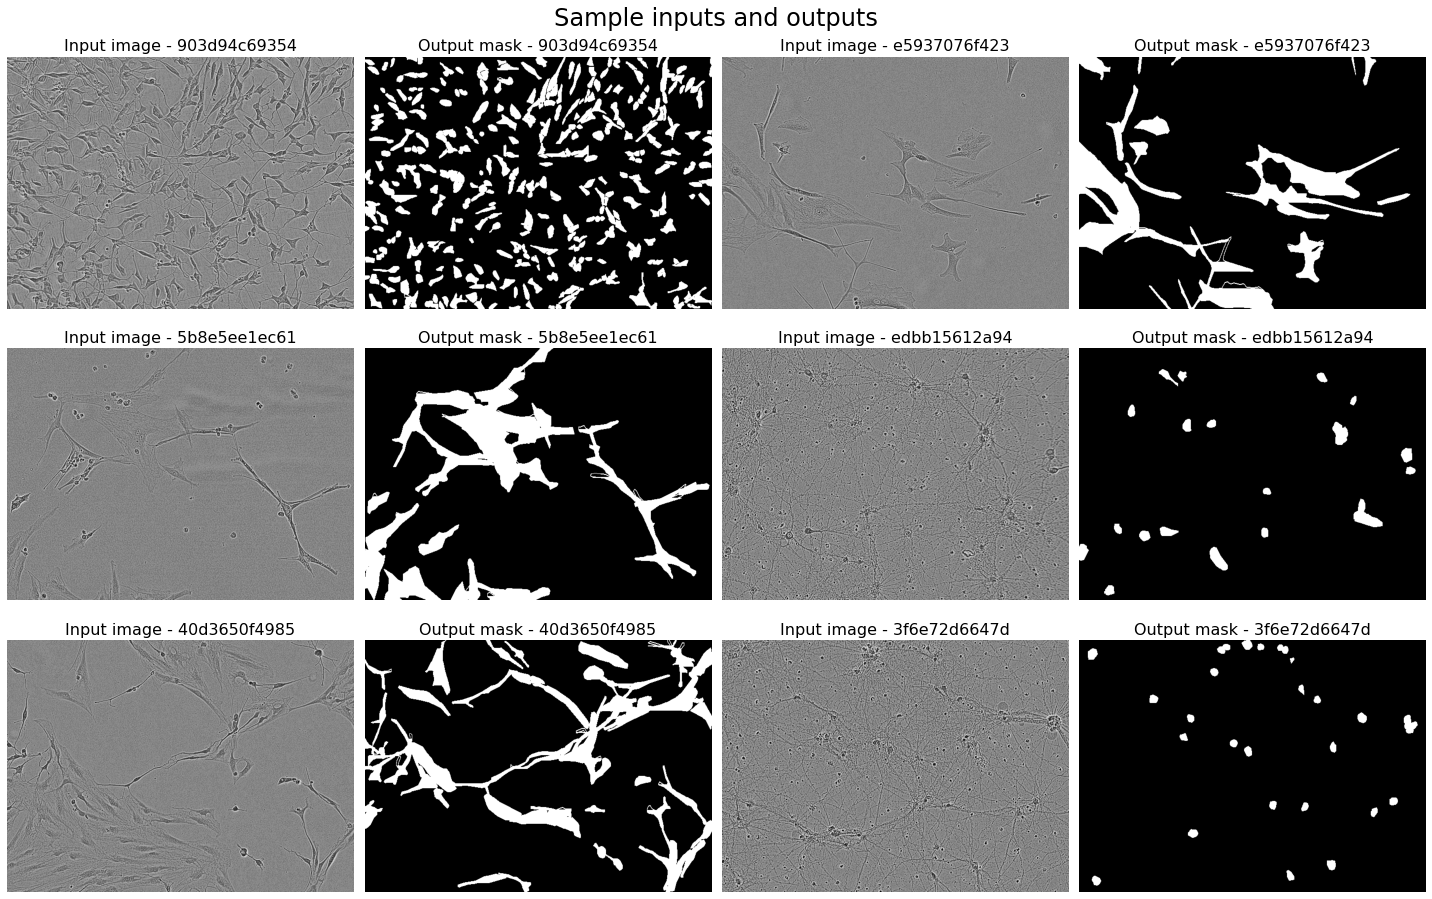

In [7]:
image_ids = list(train_images_dict.keys())

plt.figure(figsize = (20 , 13))

for idx_cnt, idx_rnd_image in enumerate(np.random.randint(len(image_ids), size = 6)):
    plt.subplot(3, 4, (idx_cnt * 2) + 1)
    plt.imshow(X[idx_rnd_image], cmap = 'gray')
    plt.title(f'Input image - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(3, 4, (idx_cnt * 2) + 2)
    plt.imshow(y[idx_rnd_image], cmap = 'gray')
    plt.title(f'Output mask - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout()
plt.show()

In [8]:
model=unet_model((cfg.preprocessing.OUTPUT_SHAPE.HEIGHT, cfg.preprocessing.OUTPUT_SHAPE.WIDTH, 1))
model.compile(optimizer = Adam(cfg.training.model.LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "Sartorius"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 512, 704, 1) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 512, 704, 16) 416         Input_Layer[0][0]                
__________________________________________________________________________________________________
Max_Pool_1 (MaxPooling2D)       (None, 256, 352, 16) 0           Conv_1[0][0]                     
__________________________________________________________________________________________________
SPD_1 (SpatialDropout2D)        (None, 256, 352, 16) 0           Max_Pool_1[0][0]                 
__________________________________________________________________________________________

lr_finder = LRFinder()
with tf.device(f'/device:GPU:{cfg.training.device.GPU}'):
    _ = model.fit(X, y, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

# %load_ext tensorboard
# %tensorboard --logdir logs --bind_all

def train(cfg: OmegaConf, X: np.ndarray, y: np.ndarray) -> tf.keras.callbacks.History:
    """ Main trainings loop execution"""
    
    model_name = pathlib.Path(cfg.paths.model.MODEL_FOLDER)
    model_name = model_name.joinpath(f"{cfg.training.model.BATCH_SIZE}")
    
    tf.debugging.set_log_device_placement(True)
    tf.profiler.experimental.server.start(cfg.project_setup.tensorboard.SERVER_PORT)
    
    tb_callback = tf.keras.callbacks.TensorBoard(
        log_dir=cfg.project_setup.tensorboard.LOG_DIR,
        histogram_freq=0,
        write_graph=True,
        write_images=False,
        write_steps_per_second=False,
        update_freq='epoch',
        profile_batch=(10,20),
        embeddings_freq=0,
        embeddings_metadata=None,
    )

    early_stop = EarlyStopping(monitor = 'val_loss', patience = cfg.training.model.PATIENCE, restore_best_weights = True)
    
    with tf.device(f'/device:GPU:{cfg.training.device.GPU}'):
        history = model.fit(
            X, y,
            batch_size = cfg.training.model.BATCH_SIZE,
            epochs = cfg.training.model.EPOCHS,
            validation_split = cfg.training.model.VAL_SIZE,
            callbacks = [early_stop, tb_callback]
        )
        model.save()
    return history

%time
history=train(cfg, X, y)

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = history.epoch

plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right', fontsize = 14)
plt.ylim(0, 1)
plt.title('Loss', fontsize = 20)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right', fontsize = 14)
plt.title('Accuracy', fontsize = 20)

plt.suptitle("Evaluation Metrics", fontsize = 24)
plt.savefig('loss_and_accuracy.jpg', dpi = 150, bbox_inches = 'tight')
plt.show()

# Predicting masks

In [12]:
## Finding optimal threshold for creating a binary mask
preds = model.predict(X)
threshold_ranges = np.arange(0.25, 0.76, 0.05)

accuracies = []

for threshold in threshold_ranges:
    pred_mask = Binarizer(threshold = threshold).transform(preds.reshape(-1, 1)).reshape(preds.shape)
    accuracies.append((pred_mask == y).sum() / pred_mask.size)

threshold_results_df = pd.DataFrame({
    'threshold': threshold_ranges,
    'accuracy': accuracies
})

threshold_results_df.round(3).sort_values('accuracy', ascending = False)

,threshold,accuracy
4,0.45,0.898
3,0.40,0.897
5,0.50,0.895
6,0.55,0.892
2,0.35,0.890
7,0.60,0.890
8,0.65,0.889
9,0.70,0.889
10,0.75,0.888
1,0.30,0.876


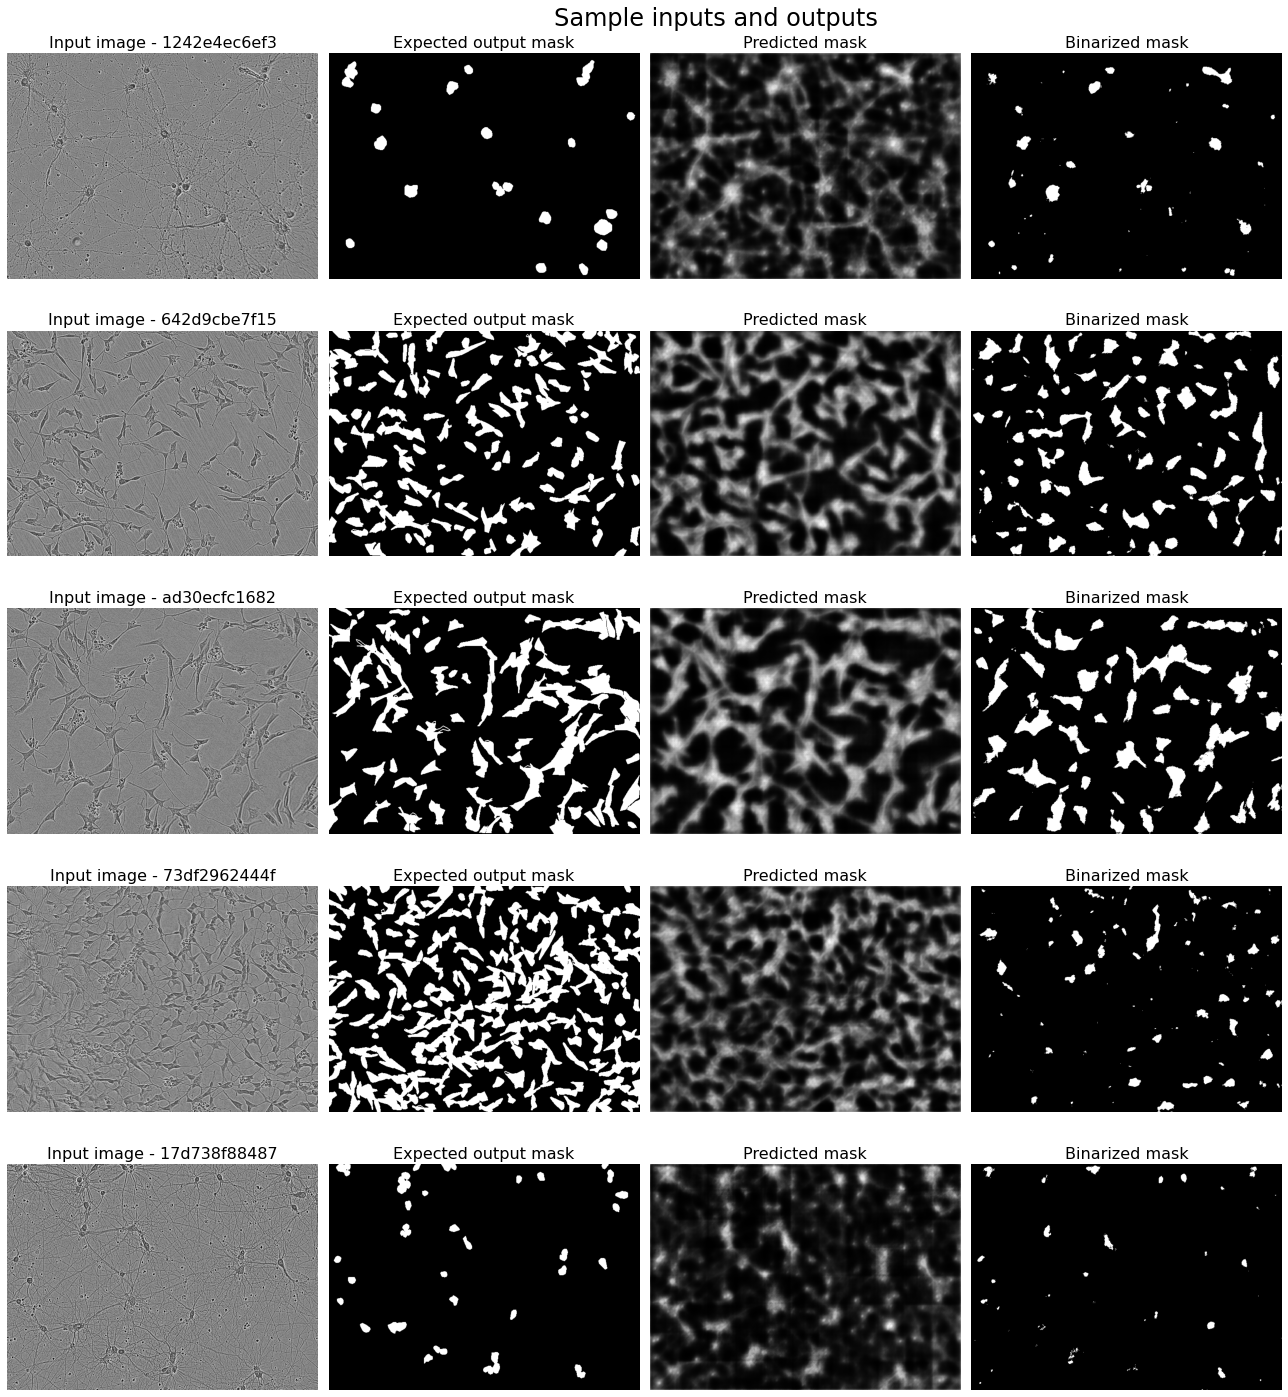

In [16]:
# Visualizing Predictions with optimal threshold for creating binary mask
num_preds = 5
sample_pred_ids = np.random.randint(len(X), size = num_preds)

pred_y = model.predict(X[sample_pred_ids])
pred_y_mask = Binarizer(threshold = threshold_results_df['threshold'].iloc[0]).transform(pred_y.reshape(-1, 1)).reshape(pred_y.shape)

plt.figure(figsize = (20 , 20))
for i in range(num_preds):
    plt.subplot(num_preds, 4, (4 * i) + 1)
    plt.imshow(X[sample_pred_ids[i]], cmap = 'gray')
    plt.axis('off')
    plt.title(f'Input image - {image_ids[sample_pred_ids[i]]}', fontsize = 16)
    
    plt.subplot(num_preds, 4, (4 * i) + 2)
    plt.imshow(y[sample_pred_ids[i]], cmap = 'gray')
    plt.axis('off')
    plt.title('Expected output mask', fontsize = 16)
    
    plt.subplot(num_preds, 4, (4 * i) + 3)
    plt.imshow(pred_y[i], cmap = 'gray')
    plt.axis('off')
    plt.title('Predicted mask', fontsize = 16)
    
    plt.subplot(num_preds, 4, (4 * i) + 4)
    plt.imshow(pred_y_mask[i], cmap = 'gray')
    plt.axis('off')
    plt.title('Binarized mask', fontsize = 16)
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout(rect = [0, 0, 0.90, 1])
plt.show()

# Convert predicted mask into individual cells and encode RLE

In [36]:
img_ids = []
rle_encondings = []
for i in range(num_preds):
    img_id = image_ids[sample_pred_ids[i]]
    img_ids.append(img_id)
    
    rle_encoding = rle_encode(pred_y_mask[i])
    rle_encondings.append(rle_encoding)

sample_submission = pd.DataFrame({
    'id': img_ids,
    'predicted': rle_encondings
})

In [37]:
sample_submission

,id,predicted
0,1242e4ec6ef3,22351 9 22363 1 22844 2 22847 2 23054 15 23540...
1,642d9cbe7f15,354 2 358 1 487 1 498 1 502 1 510 3 618 2 622 ...
2,ad30ecfc1682,130 1 134 3 138 1 836 7 1539 8 2144 4 2241 11 ...
3,73df2962444f,1 1 362 5 1065 6 1770 3 2473 4 3175 6 3781 1 3...
4,17d738f88487,2393 1 2395 1 3095 6 3561 1 3798 9 4261 1 4263...
